<a href="https://colab.research.google.com/github/RGologorsky/fastmri/blob/master/01_kspace_learner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Better to learn in kspace or image space?

## Overview

Study based on "Transfusion: Understanding Transfer Learning for Medical Imaging"

- Small architechtures perform comparably to large ones for medical tasks
- Perf on ImageNet pretraining is not indicative of perf on final medical task

Compare:

1. Task domain: learn in kspace vs learn in image space
2. Param init: w/ and wo/ transfer learning/pretraining 
3. Architcture: small vs. large  arch

First experiment: task domain
- Train a small model from scratch: **learn in kspace**
- Train a small model from scratch: learn in image space

## Setup

In [0]:
PROJ       = "fastmri"

In [2]:
# Mount Google Drive
from google.colab import drive # import drive from google colab
from pathlib import Path 

ROOT = "/content/drive"     # default location for the drive
drive.mount(ROOT)           # mount google drive at /content/drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
ALL_PROJ_PATH = Path(ROOT)/"My Drive/fastai_proj/"  # path to all projects 
PROJ_PATH   = ALL_PROJ_PATH/PROJ                    # path to project on PROJ
PROJ_PATH.mkdir(parents=True, exist_ok=True)        # make dir in PROJ to house Github

In [4]:
%run "$PROJ_PATH/common_constants_env.ipynb" # pip install fastai, fastmri, etc

pip install fastai2
git clone fastMRI
pip install ISMRMRD
pip install fasMRI req
sys append /content/fastMRI
imports


## Data

### MRI data

In [0]:
import json

In [0]:
ds_name = "knee_singlecoil_val" # dataset name
DS2DIR = {"knee_singlecoil_val": "singlecoil_val"}

In [7]:
path_json = PROJ_PATH/"data"/DS2DIR[ds_name]/"fn2attr.json"
path_json

Path('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/fn2attr.json')

In [8]:
%time fn2attr = json.load(path_json)

CPU times: user 1.63 ms, sys: 0 ns, total: 1.63 ms
Wall time: 971 ms


In [0]:
fn2attr_items = L(i for i in fn2attr.items())

In [10]:
fn2attr_items

(#40) [('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000631.h5', {'n_slices': 40, 'kspace_shape': [40, 640, 372], 'padding_left': 19, 'padding_right': 354}),('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000314.h5', {'n_slices': 32, 'kspace_shape': [32, 640, 372], 'padding_left': 19, 'padding_right': 354}),('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000031.h5', {'n_slices': 40, 'kspace_shape': [40, 640, 372], 'padding_left': 19, 'padding_right': 354}),('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000480.h5', {'n_slices': 33, 'kspace_shape': [33, 640, 372], 'padding_left': 19, 'padding_right': 354}),('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000071.h5', {'n_slices': 35, 'kspace_shape': [35, 640, 372], 'padding_left': 19, 'padding_right': 354}),('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000537.h5', {'n_slices': 35, 'kspace_shape': [3

### Imagenette data

In [11]:
path_net = untar_data(URLs.IMAGENETTE_160)
fnames_net = get_image_files(path_net)

In [12]:
fn_net_test = fnames_net[0]
fn_net_test

Path('/root/.fastai/data/imagenette2-160/val/n03394916/n03394916_49952.JPEG')

## Kspace Transform

In [0]:
# apparently scipy fft interleaves Real+Im of single px as 2 adj vals 
# https://stackoverflow.com/questions/38476359/fft-on-image-with-python/38507628
import scipy.fft as fp

In [0]:
fn2bw = Pipeline([PILImageBW.create])

# ck = centered kspace, is = image space
fn2ck = Pipeline([PILImageBW.create, np.array, fp.rfft2, np.fft.fftshift])

im2ck = Pipeline([np.array, fp.rfft2, np.fft.fftshift])
ck2im  = Pipeline([np.fft.ifftshift, fp.irfft2, PILImageBW.create])

# showing amplitude (not phase)
k2amp   = Pipeline([add(1e-9), np.log, np.abs])
#amp2im = Pipeline([fp.irfft2, np.fft.ifftshift])

# expects batch of kslices. T.ifft includes shifting
xb2im = Pipeline([T.to_tensor, T.ifft2, T.complex_abs])

# xb is tensor
xbt2amp = Pipeline([T.ifft2, T.complex_abs])

# np ks2im
ks2im_np = Pipeline([np.fft.ifftshift, fp.ifft2, np.fft.fftshift, np.abs])

# makes a k slice into a batch, applied xb2im
def ks2im(kslice): return xb2im(kslice[None,:])[0]
#def ks2im(kslice): return xb2im(kslice.unsqueeze(0))[0]

In [0]:
# KS is a complex ndarray representing k slices that knows how to show itself (amp)
class KS(np.ndarray):
    def __new__(cls, input_array): return np.asarray(input_array).view(cls)
    def show(self, ctx=None, **kwargs):    show_image(ks2im_np(self), ctx=ctx, cmap = "gray", **kwargs)
    def show_im(self, ctx=None, **kwargs): show_image(ks2im_np(self), ctx=ctx, cmap = "gray", **kwargs)

In [0]:
# given fn2attr dict, indexes into array of kspace slices
class KSliceTfm(Transform):
  def __init__(self, fn2attr_items, is_valid=False):
    self.fn2attr_items, self.is_valid = fn2attr_items, is_valid
    self.n_slices = [attr["n_slices"] for (_, attr) in self.fn2attr_items]
    self.cumsum = np.cumsum(self.n_slices)
    self.total_n_slices = self.cumsum[-1]

  def encodes(self, i) -> KS:
    fn2attr_idx  = np.searchsorted(self.cumsum, i)
    slice_idx = i - self.cumsum[fn2attr_idx]

    fname = self.fn2attr_items[fn2attr_idx][0]

    with h5py.File(fname, 'r') as data:
      kslice = data['kspace'][slice_idx]

    return KS(kslice)


## Test kspace transform

In [0]:
# Viz, plot images function

def idx(lst,i, default=None): return lst[i] if i < len(lst) else default
def rep(o,n): return [o for _ in range(n)]

# useful fn to plot image fns in *args
def plot(imgs, titles, cmaps, nrows=1, ncols=1, figsize = (6,6), **kwargs):
  fig,axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
  axes = axes.flatten()
  for i,im in enumerate(imgs): 
    axes[i].imshow(im, cmap=idx(cmaps,i))
    axes[i].set_xticklabels([]), axes[i].set_yticklabels([])
    axes[i].set_title(idx(titles,i))
    axes[i].set_xlabel(im.shape)
  fig.show()

#### Natural image to kspace and back

In [0]:
im_test  = fn2bw(fn_net_test)
ck_test  = fn2ck(fn_net_test)
amp_test = k2amp(ck_test)
im_rev   = ck2im(ck_test)

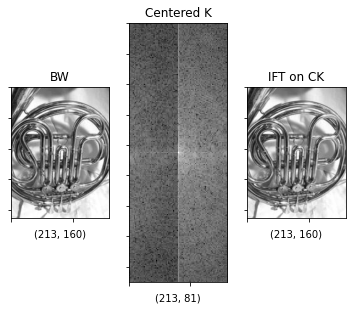

In [21]:
plot([im_test, amp_test, im_rev], ["BW", "Centered K", "IFT on CK"], rep("gray", 3), ncols=3)

In [22]:
type(amp_test), amp_test.shape

(numpy.ndarray, (213, 81))

### MRI k space to MR image

In [0]:
kslices = KSliceTfm(fn2attr_items)

In [24]:
total_n_slices = kslices.total_n_slices
total_n_slices

1356

In [0]:
i = np.random.randint(0,total_n_slices)

In [26]:
x = kslices(i)
i, x.shape, type(x)

(346, (640, 372), __main__.KS)

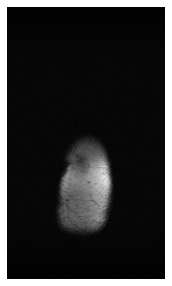

In [27]:
x.show()

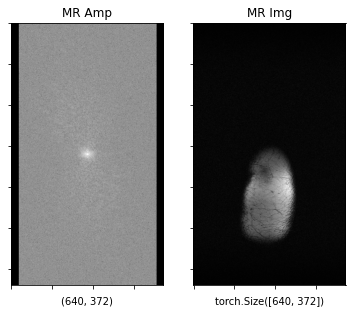

In [28]:
plot([k2amp(x), ks2im(x)], ["MR Amp", "MR Img"], ["gray_r", "gray"], ncols=2)

### try to make image a double - come back later

In [0]:
def get_concat_h(x1, x2):
    im1, im2 = PILImageBW.create(x1), PILImageBW.create(x2)
    dst = Image.new('L', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

In [0]:
x1, x2 = k2amp(x), ks2im_np(x)

In [0]:
x1, x2 = np.array(x1), np.array(x2)

In [239]:
type(x1), type(x2), x1.shape, x2.shape

(numpy.ndarray, numpy.ndarray, (640, 372), (640, 372))

In [0]:
im1, im2 = PILImageBW.create(x1), PILImageBW.create(x2)

In [238]:
im1

OSError: ignored

PILImageBW mode=F size=372x640

# Compare learning in kspace to learning in image space

In [29]:
total_n_slices

1356

In [0]:
split_idxs = RandomSplitter()(range(total_n_slices))

In [31]:
split_idxs

((#1085) [1342,254,1050,592,252,1188,605,881,1346,987...],
 (#271) [349,756,1171,693,613,1267,939,1138,639,998...])

In [0]:
%time tl = TfmdLists(range(total_n_slices), tfms=kslices, splits=split_idxs)

In [0]:
y = tl.train(0)

In [34]:
type(y)

__main__.KS

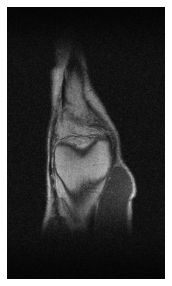

In [35]:
show_at(tl, 1230)

In [0]:
# after batch apply mask to x of kslice or categorize y, num_workers, bs
# tdl = TfmdDL()

In [0]:
# train_tl = TfmdLists(fn2attr, tfms=[kslices])

# Train imagenette classifier standard

## Dataloader

In [0]:
# do data aug later - for now resize by center crop/pad image

In [0]:
lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)

In [0]:
# in black & white, normalization from batch (not imagenet stats, to match kspace)

In [0]:
img_dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                       get_items = get_image_files,
                       get_x = fn2bw,
                       get_y = Pipeline([parent_label, lbl_dict.__getitem__]),
                       splitter = GrandparentSplitter(valid_name='val'),
                       item_tfms = RandomResizedCrop(128, min_scale=0.35),
                       batch_tfms = Normalize
)

In [0]:
img_dls = img_dblock.dataloaders(path_net)


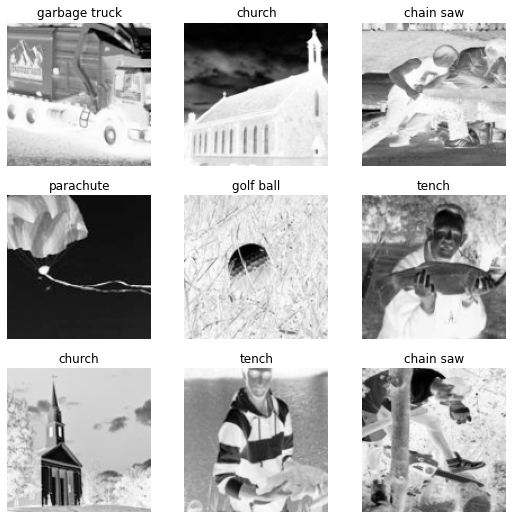

In [43]:
img_dls.show_batch()

# Train imagenette classifer in kspace

## Dataloader

Question: would subsample mask in kspace correspond to something like random resampled crop in image space?

In [0]:
# natural image to centered kspace
class CK(np.ndarray):
    @classmethod
    def create(cls, fn):  return cls(fn2ck(fn))
    def __new__(cls, input_array): return np.asarray(input_array).view(cls)

    def show_im(self, ctx=None, **kwargs): show_image(ck2im(self), ctx=ctx, cmap = "gray", **kwargs)
    def show_amp(self, ctx=None, **kwargs): show_image(k2amp(self), ctx=ctx, cmap = "gray", **kwargs)

    def show(self, ctx=None, **kwargs): self.show_amp(ctx, **kwargs)


In [0]:
  ck_random_crop  = Pipeline([
                    np.fft.ifftshift, fp.irfft2, PILImageBW.create, # convert KS to real image
                    RandomResizedCrop(128, min_scale=0.35), # random crop
                    np.array, fp.rfft2, np.fft.fftshift, # convert to centered kspace,
                  ])

In [0]:
class CKTensorImage(TensorImageBase):
    _show_args = {'cmap':'gray'}
    def show(self, ctx=None, **kwargs):
        amps = xbt2amp(self)
        return show_image(amps, ctx=ctx, **{**self._show_args, **kwargs})

In [0]:
ArrayImageBase??

In [0]:
class ToT(Transform):
  order = 10 
  def encodes(self, o:CK): return T.to_tensor(o)

class CKRandomCrop(Transform):
  order = 1
  def encodes(self, o:CK): return ck_random_crop(o)


In [0]:
def ToCK(arr): return CK(arr)
def Item2T(o): return T.to_tensor(o[0]) # only x

In [0]:
def CKBlock(cls=CK): return TransformBlock(type_tfms=cls.create, item_tfms=ToT)

In [0]:
# im2ck = Pipeline([np.array, fp.rfft2, np.fft.fftshift])
# ck2im  = Pipeline([np.fft.ifftshift, fp.irfft2, PILImageBW.create])

In [0]:
# transform x into k space
ck_dblock = DataBlock(blocks = (CKBlock, CategoryBlock),
                       get_items = get_image_files,
                       get_y = Pipeline([parent_label, lbl_dict.__getitem__]),
                       splitter = GrandparentSplitter(valid_name='val'),
                       item_tfms = CKRandomCrop,
                       batch_tfms = [Normalize],
)

### Test

In [0]:
test = fnames_net[0]

In [65]:
test_img = PILImageBW.create(test)
test_img.shape

(213, 160)

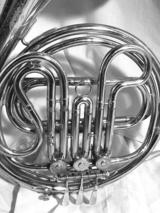

In [66]:
test_img

(None, (213, 81))

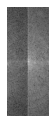

In [67]:
a = CK.create(test)
a.show(), a.shape

(None, (213, 81))

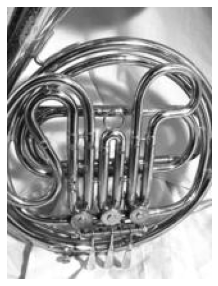

In [68]:
a.show_im(), a.shape

In [69]:
rev_img = ck2im(a)
rev_img.shape

(213, 160)

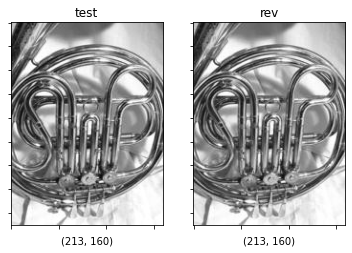

In [70]:
plot([test_img, rev_img], ["test", "rev"], rep("gray", 2), ncols=2)

In [0]:
# YAY
np.testing.assert_array_almost_equal(np.array(test_img), np.array(rev_img))

In [90]:
at = T.to_tensor(a)
at.shape, type(at)

(torch.Size([213, 81, 2]), torch.Tensor)

In [0]:
# debug
# ck_dblock.summary(path_net, bs=2)

In [0]:
ck_dls = ck_dblock.dataloaders(path_net)

### Viz

In [0]:
xb,yb = ck_dls.one_batch()

In [131]:
xb.shape, type(xb), yb.shape, type(yb)

(torch.Size([64, 128, 65, 2]),
 torch.Tensor,
 torch.Size([64]),
 fastai2.torch_core.TensorCategory)

In [156]:
amps = xbt2amp(xb)
amps.shape, type(amps)

(torch.Size([64, 128, 65]), torch.Tensor)

In [0]:
IntToFloatTensor??

In [158]:
ck_dls._types, type(xb)

({tuple: [torch.Tensor, fastai2.torch_core.TensorCategory]}, torch.Tensor)

In [0]:
??TensorImageBase

In [154]:
ck_dls.show_batch(TensorImageBW(xbt2amp(xb)))

TypeError: ignored

In [133]:
at.shape, type(at)

(torch.Size([213, 81, 2]), torch.Tensor)

In [139]:
c = T.complex_abs(at)
c.shape, type(c)

(torch.Size([213, 81]), torch.Tensor)

In [140]:
d = np.asarray(c)
d.shape, type(d)

((213, 81), numpy.ndarray)

In [143]:
e = PILImageBW.create(d)
e

OSError: ignored

PILImageBW mode=F size=81x213

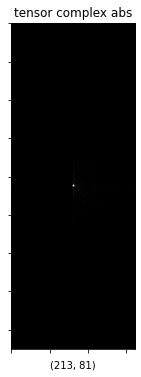

In [145]:
plot([d], ["tensor complex abs"], ["gray"])

In [388]:
k_dls.train

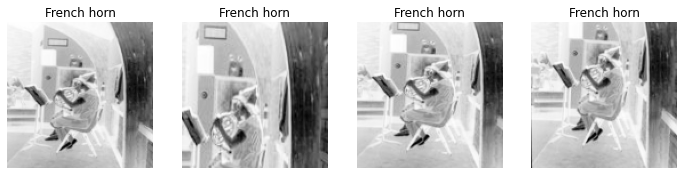

In [392]:
k_dls.train.show_batch(max_n=4, nrows=1, unique=True)

## Convert imagenet to kspace in polar coord

In [0]:
def get_data(url, presize, resize):
  